In [0]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
data = np.load(r"/content/drive/My Drive/Marko/Model_learning/GAN/HSI-Classification-GAN/dataset/ds.npy")
gt = np.load(r"/content/drive/My Drive/Marko/Model_learning/GAN/HSI-Classification-GAN/dataset/gt.npy")
print(data.shape)
print(gt.shape)

(145, 145, 200)
(145, 145)


In [0]:
H = data.shape[0]
W = data.shape[1]
#归一化
scaler = StandardScaler()
voxel = scaler.fit_transform(data.reshape(-1, data.shape[-1]))
print(voxel.shape)
#PCA 
pca = PCA(n_components=30)
principalComponents = pca.fit_transform(voxel)
print(principalComponents.shape)
# principalDF = pd.DataFrame(data=principalComponents, columns=["pc%d"%x for x in range(30)])
# print(principalDF)
fullDataX = principalComponents.reshape(H,W,30)
fullDataY = gt
print("fullDataX:",fullDataX.shape)
print("fullDataY:",gt.shape)

(21025, 200)
(21025, 30)
fullDataX: (145, 145, 30)
fullDataY: (145, 145)


In [0]:
import cv2
from skimage.util import view_as_windows
np.random.seed(666)
print(fullDataX.shape)
#(145,145,30) -> (176,176,30)
paddedDatax = cv2.copyMakeBorder(fullDataX, 16, 15, 16, 15, cv2.BORDER_CONSTANT, value=0)
print(paddedDatax.shape)
#(176,176,30) -> (145,145,1,32,32,30) 176-32+1=145 || 3-3+1=1
X_train = view_as_windows(paddedDatax, (32, 32, 30), step=1).reshape(-1,32,32,30)
#(145,145,1,32,32,30) -> (21025,32,32,03)
y_train = fullDataY.reshape(-1,)
#shuffle
p = np.random.permutation(len(X_train))
X_train=X_train[p]
y_train=y_train[p]
print(X_train.shape)
print(y_train.shape)

(145, 145, 30)
(176, 176, 30)
(21025, 32, 32, 30)
(21025,)


In [0]:
X_train = X_train[y_train>0,:,:,:]
y_train = y_train[y_train>0]
y_train = y_train - 1 #1-17 -> 0-16
print(X_train.shape)
print(y_train.shape)
data = X_train
label = y_train

(10249, 32, 32, 30)
(10249,)


In [0]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

tf.random.set_seed(666)
batch_sz=128
X, test_data, Y, test_label = train_test_split(data, label, test_size=0.1, random_state=666)
train_data, valid_data, train_label, valid_label = train_test_split(X, Y, test_size=0.2, random_state=666)

print(train_data.shape, train_label.shape)
print(valid_data.shape, valid_label.shape)
print(test_data.shape, test_label.shape)


(7379, 32, 32, 30) (7379,)
(1845, 32, 32, 30) (1845,)
(1025, 32, 32, 30) (1025,)


##Model_define

In [0]:
from tensorflow.keras.layers import Dense, Conv3D, Conv2D, Flatten, Reshape, Dropout, Input, Activation, BatchNormalization, MaxPool3D
from tensorflow.keras.models import Model
import tensorflow as tf
#input_layer = (32,32,30,1)
input_layer = Input(shape=(32,32,30,1))
#Conv3D_layer

Conv1 = Conv3D(filters=16, kernel_size=(3,3,3), strides=(2,2,2))(input_layer)
Bn1 = BatchNormalization()(Conv1)
LR1 = tf.nn.leaky_relu(Bn1,alpha=0.2)
Pool1 = MaxPool3D(pool_size=(2,2,2))(LR1)

Conv2 = Conv3D(filters=32, kernel_size=(3,3,3), strides=(2,2,2))(Pool1)
Bn2 = BatchNormalization()(Conv2)
LR2 = tf.nn.leaky_relu(Bn2,alpha=0.2)
Pool2 = MaxPool3D(pool_size=(2,2,2))(LR2)

flatten_layer = Flatten()(Pool2)

fc = Dense(units=16, activation="softmax")(flatten_layer)

Conv3D_net = Model(input_layer, fc)

In [0]:
Conv3D_net.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 30, 1)]   0         
_________________________________________________________________
conv3d (Conv3D)              (None, 15, 15, 14, 16)    448       
_________________________________________________________________
batch_normalization (BatchNo (None, 15, 15, 14, 16)    64        
_________________________________________________________________
tf_op_layer_LeakyRelu (Tenso [(None, 15, 15, 14, 16)]  0         
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 7, 7, 7, 16)       0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 3, 3, 3, 32)       13856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 3, 3, 3, 32)       128   

In [0]:
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import os 
path = r"/content/drive/My Drive/Marko/Model_learning/GAN/HSI-Classification-GAN/EI_PAPER/weights_and_models"
save = os.path.join(path,"best_Conv3D_net.h5")

adam = optimizers.Adam(learning_rate=0.0005, decay=1e-6)
checkpoint = ModelCheckpoint(save, monitor='acc', verbose=0, save_best_only=True, mode='max')
earlystopping = EarlyStopping(patience=10, min_delta=1e-4)
callbacks_list = [checkpoint,earlystopping]
Conv3D_net.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [0]:

os.environ["TF_CPP_MIN_LOG_LEVEL"]="3"
history = Conv3D_net.fit(train_data, train_label,
              epochs=100,
              batch_size=batch_sz,
              validation_data=(valid_data, valid_label),
              callbacks=callbacks_list)


Epoch 1/100
58/58 [==============================] - 1s 20ms/step - loss: 1.8698 - accuracy: 0.4522 - val_loss: 1.5912 - val_accuracy: 0.5046
Epoch 2/100
58/58 [==============================] - 1s 17ms/step - loss: 1.0011 - accuracy: 0.7268 - val_loss: 1.0815 - val_accuracy: 0.7328
Epoch 3/100
58/58 [==============================] - 1s 17ms/step - loss: 0.6741 - accuracy: 0.8306 - val_loss: 0.7792 - val_accuracy: 0.8038
Epoch 4/100
58/58 [==============================] - 1s 17ms/step - loss: 0.4870 - accuracy: 0.8836 - val_loss: 0.5641 - val_accuracy: 0.8650
Epoch 5/100
58/58 [==============================] - 1s 18ms/step - loss: 0.3643 - accuracy: 0.9207 - val_loss: 0.4150 - val_accuracy: 0.9051
Epoch 6/100
58/58 [==============================] - 1s 18ms/step - loss: 0.2814 - accuracy: 0.9455 - val_loss: 0.3318 - val_accuracy: 0.9274
Epoch 7/100
58/58 [==============================] - 1s 17ms/step - loss: 0.2200 - accuracy: 0.9615 - val_loss: 0.2644 - val_accuracy: 0.9491
Epoch 

In [0]:
Conv3D_net.evaluate(test_data, test_label, verbose=0)

[0.015058076940476894, 0.9960975646972656]

In [0]:
Conv3D_net.save_weights(save)

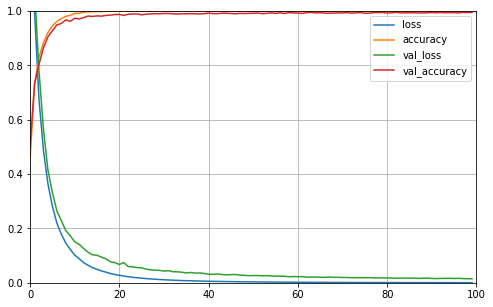

In [0]:
import matplotlib.pyplot as plt

def plot_learning_curves(history,epoch,min_val,max_val):
        pd.DataFrame(history.history).plot(figsize=(8,5))
        plt.grid(True)
        plt.axis([0, epoch, min_val, max_val])
        plt.show()
plot_learning_curves(history,100,0,1)

In [0]:
width = 145
height = 145
PATCH_SIZE = 32
numComponents = 30
def Patch(data,height_index,width_index): #0-144 -> 32-176
  height_slice = slice(height_index, height_index+PATCH_SIZE)
  width_slice = slice(width_index, width_index+PATCH_SIZE)
  patch = data[height_slice, width_slice, :] 
  return patch

In [0]:
# calculate the predicted image
outputs = np.zeros((height,width))
for i in range(height):
    for j in range(width):
        target = fullDataY[int(i), int(j)]
        if target == 0 :
            continue
        else :
            image_patch=Patch(paddedDatax,i,j)
            #print (image_patch.shape)
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1],image_patch.shape[2],1).astype('float32')                                   
            prediction = (Conv3D_net.predict(X_test_image))   
            prediction = tf.argmax(prediction, axis=-1).numpy()                     
            outputs[int(i)][int(j)] = prediction+1
print(outputs.shape)

(145, 145)


In [0]:
!pip install spectral

     |████████████████████████████████| 194kB 2.8MB/s 


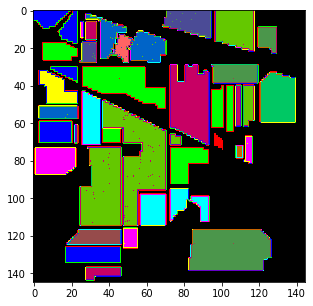

In [0]:
import spectral
# Plot the Ground Truth Image
ground_truth = spectral.imshow(classes = fullDataY,figsize =(5,5))

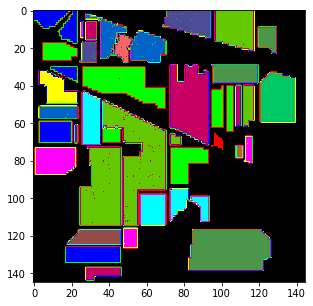

In [0]:
# Plot the Predicted image
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(5,5))